# Lab 2

##### Team Members: Alex Lopez, Chris Haub, Erin McClure-Price

Loading packages needed for the project.

In [19]:
# Importing all packages and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
import glob
import os
import seaborn as sns #may not use
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA 

#Suppress futurewarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Suppress convergence warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

#Set Figure Size
plt.rcParams["figure.figsize"] = (20,10)

The following cell establishes functions to be used in the file:

In [2]:
## setting up function to create confusion matrix
def make_confusion_matrix(model,y_actual, x_test, labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(x_test)
    cm=mt.confusion_matrix( y_actual, y_predict, labels=labels)
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Function for generating metric scores
def get_metrics_score(model,flag=True):    #model : classifier to predict values of X
    
    # defining an empty list to store train and test results
    score_list=[]
    
    #Predicting on train and tests
    pred_train = model.predict(xTrain)
    pred_test = model.predict(xTest)
    
    #Accuracy of the model
    train_acc = model.score(xTrain,yTrain)
    test_acc = model.score(xTest,yTest)
    
    #Recall of the model
    train_recall = mt.recall_score(yTrain,pred_train,pos_label="no")
    test_recall = mt.recall_score(yTest,pred_test,pos_label="no")
    
    #Precision of the model
    train_precision = mt.precision_score(yTrain,pred_train,pos_label="no")
    test_precision = mt.precision_score(yTest,pred_test,pos_label="no")

    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True:
        print("Accuracy on training set : ",model.score(xTrain,yTrain))
        print("Accuracy on test set : ",model.score(xTest,yTest))
        print("\nRecall on training set : ",mt.recall_score(yTrain,pred_train,pos_label="no"))
        print("Recall on test set : ",mt.recall_score(yTest,pred_test,pos_label="no"))
        print("\nPrecision on training set : ",mt.precision_score(yTrain,pred_train,pos_label="no"))
        print("Precision on test set : ",mt.precision_score(yTest,pred_test,pos_label="no"))
    
    return score_list # returning the list with train and test scores

def getCP(column):
    xCount = column.value_counts()
    xPercentages = xCount/len(column)
    outData = pd.DataFrame()
    outData['Counts'] = xCount
    outData['Percent of Total'] = xPercentages
    return outData

## Data Preparation

### Part 1

***Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.***

The first step was to load necessary packages and our dataset, UCI's "Bank Marketing Data Set" (https://archive.ics.uci.edu/ml/datasets/bank+marketing). In addition, we created variables for indexing both the continuous and categorical variables within the dataset.

In [3]:
#Import Dataset from github repo
bankData = pd.read_csv('bank-additional-full.csv', sep=';', na_values="unknown")
#Optional: Add in index column
#bankData.insert(0, 'Sample_ID', range(1,len(bankData)+1))

#Creating variables for indexing continuous and categorical variables
conCol = ['age', 'duration', 'campaign', 'previous', 'emp.var.rate', 
          'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

catCol = ['job', 'marital', 'education', 'housing', 'loan', 
          'contact', 'month', 'day_of_week'] # Default is removed from this list because it is not used 

The next step was to drop entries with missing values, this removed 10,701 rows leaving 30,488 rows which, as discussed in previous assignments, was sufficient for the analysis requirements. In addition, we removed those columns that were unbalanced or appeared to have little to no importance within the model. The removed columns included 'duration', 'default', and 'pdays'.

The reasoning for removing the 'duration' and 'default' columns was that the former's distribution was highly skewed and just describes the time spent on the call, which cannot be known until after the call is ended. Obviously, those callers who take out a long-term deposit will naturally spend more time on a call, which indicates that this variable is likely to bias the results of a model. The latter was removed due to its consisting of almost entirely "no" responses with a total of 3 "yes" responses, making it highly unbalanced which infers that it would also bias any results. We ultimately chose to remove 'pdays' because it refers to how many days had passed since a customer had been contacted during the previous campaign, and did not appear to be relevant. In addition, the dataset is skewed since the majority of the customers in this dataset chose "no" to a short term deposit and we wanted to dedicate our resources to those customers who had said "yes".

Finally, we chose to refine the 'poutcome' variable by excluding those customers who had never been contacted in a previous campaign. Our reasoning was that we would want to focus our resources on those customers who had previously been contacted since we knew their responses.


In [4]:
#Removing missing values
bankData2 = bankData.dropna()

print(getCP(bankData2.poutcome))

#Refining dataframe to focus on population that has no previous campaigns
bankData2 = bankData2.drop(bankData2[(bankData2.poutcome!='nonexistent') ].index)
print(getCP(bankData2.poutcome))

#Creating df of removed rows for optional analysis
previousCampaigns = bankData2.drop(bankData2[(bankData2.poutcome == 'nonexistent') ].index)

#Removing default, duration, pdays, and poutcome columns
bankData2 = bankData2.drop(['default','duration', 'pdays', 'poutcome'], axis=1)
print(bankData2.shape)
bankData2.head()

             Counts  Percent of Total
nonexistent   25836          0.847415
failure        3461          0.113520
success        1191          0.039065
             Counts  Percent of Total
nonexistent   25836               1.0
(25836, 17)


,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,1,0,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,yes,no,telephone,may,mon,1,0,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,1,0,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,yes,telephone,may,mon,1,0,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,telephone,may,mon,1,0,1.1,93.994,-36.4,4.857,5191.0,no


We looked at the simple statistics of the continuous variables and noted that the means were close to the median, indicating that their distributions were fairly symmetrical and would not require any mathematical treatments prior to analysis.

In [5]:
#Getting basic statistical overview of continuous variables using the describe function
bankData2.describe()

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,25836.000000,25836.000000,25836.0,25836.000000,25836.000000,25836.000000,25836.000000,25836.000000
mean,38.842081,2.624361,0.0,0.238470,93.592630,-40.452427,3.814680,5176.048192
std,9.904549,2.880938,0.0,1.512054,0.557312,4.458733,1.643046,66.103034
min,18.000000,1.000000,0.0,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,31.000000,1.000000,0.0,-1.800000,93.200000,-42.700000,1.410000,5099.100000
50%,37.000000,2.000000,0.0,1.100000,93.876000,-41.800000,4.858000,5195.800000
75%,45.000000,3.000000,0.0,1.400000,93.994000,-36.400000,4.962000,5228.100000
max,95.000000,43.000000,0.0,1.400000,94.767000,-26.900000,5.045000,5228.100000


Looking at the first target variable, y, we see that it is remarkably unbalanced with over 25,000 "no" responses and less than 5,000 "yes" responses. While we could balance the target variable to even out the responses, we felt that increasing the "yes" answers would bias the outcomes of the models. Since the "no" responses are real we chose not to balance the variable in order to obtain more realistic models.

Percentages for  Y  : 
      Counts  Percent of Total
no    23264          0.900449
yes    2572          0.099551 




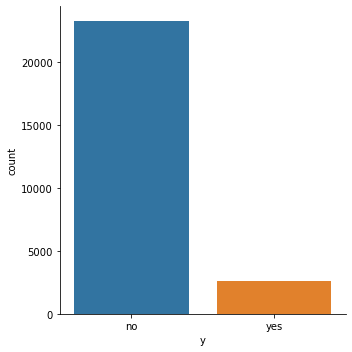

In [6]:
print("Percentages for ",'Y'," : \n",getCP(bankData2['y']),"\n\n")
sns.catplot(x='y', data = bankData2, kind = 'count')

Our second target variable, education, consists of seven levels: illiterate, basic 4, 6, and 9 years, highschool, university degree, and professional course. We noted that the majority of customers had a university degree (34%), followed by highschool (25%). The basic 9 year (14%) and professional course (14.1%) were fairly close followed by basic 4 year (8%) and then basic 6 year (5%). The illiterate level was 0.0004%. Since the diferences between the levels was less than 30%, with the exception of 'illiterate', we chose to keep the data as is.

The following is a breakdown of the class counts of the Education Variable:

 university.degree      8777
high.school            6458
professional.course    3699
basic.9y               3682
basic.4y               2008
basic.6y               1202
illiterate               10
Name: education, dtype: int64


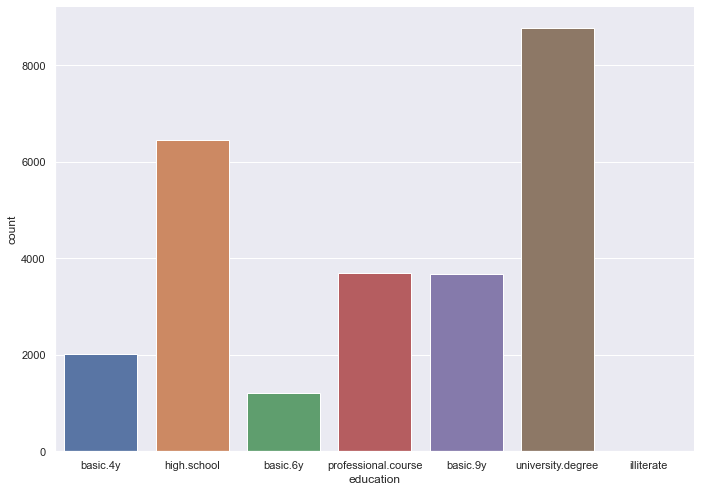

In [7]:
print("The following is a breakdown of the class counts of the Education Variable:\n\n",bankData2.education.value_counts())
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.catplot(x='education', data = bankData2, kind = 'count', height=7, aspect=11.7/8.27)

The code below returns the counts and percentages of each level in the categorical variables. For jobs, most customers are in admin (28%) followed by blue-collar (19%) and technician (18%). The marital status for the majority of customers is married (57%), followed by single (31%), and divorced (12%). There were more customers with university degrees (34%) than all other levels of education, while the those customers who had housing loans (54%) were close to those without housing loans (46%).

From looking at the loan variable, we noted that only 16% of customers had taken out a personal loan, and from the contact variable we saw that the majority of customers used cellphones (67%) over telephones.

Interestingly, significantly more customers were contacted in the month of May (32%) than any other month, though we cannot make any inferences about why this would be the case since it is likely due to the bank's protocols. The day of the week did not appear to have any influence on customer count, while the variable for outcome of the previous marketing campaign, poutcome, did show that the majority of customers had nonexistent outcomes (85%).


In [8]:
for i in catCol:
    print("Percentages for ",i," : \n",getCP(bankData2[i]),"\n\n")

Percentages for  job  : 
                Counts  Percent of Total
admin.           7368          0.285183
blue-collar      4944          0.191361
technician       4739          0.183426
services         2439          0.094403
management       1945          0.075283
self-employed     943          0.036499
entrepreneur      941          0.036422
retired           895          0.034642
unemployed        607          0.023494
housemaid         600          0.023223
student           415          0.016063 


Percentages for  marital  : 
           Counts  Percent of Total
married    14969          0.579385
single      7838          0.303375
divorced    3029          0.117240 


Percentages for  education  : 
                      Counts  Percent of Total
university.degree      8777          0.339720
high.school            6458          0.249961
professional.course    3699          0.143172
basic.9y               3682          0.142514
basic.4y               2008          0.077721
basic.6y  

We performed a One Hot encoding on the categorical variables and stored the resulting dataset as a separate dataset before concatenating it with the continuous variables from the cleaned dataset.

In [9]:
#Declaring Scalar object
scl_obj = StandardScaler()

#One hot encoding of ALL categorical variables
OneHotDF = pd.get_dummies(bankData2[catCol],drop_first=False)

#Scaling non-encoded data
conVar = bankData2.select_dtypes(exclude='object')
colnames = pd.Series(conVar.columns)
conVarScaled = scl_obj.fit_transform(conVar)
conVarScaled = pd.DataFrame(data = conVarScaled, columns= colnames)

#Combining with continuous variables from cleaned dataset
OneHotDF = OneHotDF.reset_index()
OneHotDF.pop('index')
OneHotDF = pd.concat([conVarScaled,OneHotDF], axis = 1)
OneHotDF.head()

#https://github.com/jakemdrew/DataMiningNotebooks/blob/master/01.%20Pandas.ipynb

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,1.732361,-0.563842,0.0,0.569786,0.720204,0.908892,0.634395,0.226194,0,0,...,0,1,0,0,0,0,1,0,0,0
1,-0.185987,-0.563842,0.0,0.569786,0.720204,0.908892,0.634395,0.226194,0,0,...,0,1,0,0,0,0,1,0,0,0
2,0.116910,-0.563842,0.0,0.569786,0.720204,0.908892,0.634395,0.226194,1,0,...,0,1,0,0,0,0,1,0,0,0
3,1.732361,-0.563842,0.0,0.569786,0.720204,0.908892,0.634395,0.226194,0,0,...,0,1,0,0,0,0,1,0,0,0
4,2.035258,-0.563842,0.0,0.569786,0.720204,0.908892,0.634395,0.226194,1,0,...,0,1,0,0,0,0,1,0,0,0


The next step was to normalize and finalize preparing the dataset. We used SciKit's StandardScaler, which would fix any non-Gaussian curves to center around zero and force all standard deviations to one.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

### Part 2

***Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).***

As previously stated, the final, cleaned, dataset we used had all rows with missing data removed removed mainly because the large size of the original data set allowed us to do so while maintaining the assignment's requirements. This meant that rather than trying to impute categorical variables, we could simply remove those rows while still meeting our instance size requirements.

After the missing variables were removed, we one-hot-encoded the categorical features so that we could work with only numeric features. This format is required for certain modeling algorithms that we planned to utilize for the analyses.

Next, the data set was converted from a data frame to a list format. This was done in order to satisfy the cross validation training algorithim that requires this type of data input.

Finally, the numeric, list format data set was scaled. This is required for many classifiers including, but not limited to, Random Forest and k-Nearest Neighbor.

## Modeling and Evaluation

### Part 1

***Choose and explain your evaluation metrics that you will use (i.e., accuracy,
precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.***

For the goal of predicting the target variable, "y", we chose to focus on precision because our goal was to minimize the number of false positives which, in turn, means minimizing the potential loss of funds spend towards marketing. This last point is especially important because, we would not want to direct a client to waste resources on customers who we predict will say "yes" to a loan when they will actually just say "no". Alternatively, if the marketing budget of a client was not a concern, focusing on recall would maximize potential customers saying "yes". In short, precision focuses on those customers who are most likely to choose "yes" to a short term loan, while recall focuses on maximizing potential returns. The reason why we chose precision over accuracy for this goal was because, as we previously showed, our target variable is unbalanced with approximately 87% "no" responses which infers that the accuracy of the model would be high but would also be biased towards over-predicting "no" responses.

For the goal of predicting the level of education a customer has that will make them more likely to say "yes" to a loan we chose to use accuracy. Our reasoning for using accuracy was that the target variable in this case, education, was not greatly unbalanced with a reasonable differences between levels. Since we did not have to worry about unbalanced data, we chose accuracy because we wanted to know the percentage of correct predictions.


### Part 2

***Choose the method you will use for dividing your data into training and
testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why
your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.***

An important aspect of choosing our method for training/testing splitting was analyzing the balance of our target variable. We did so by comparing the number of responses of each level within the target variable.

In [10]:
def getCP(column):
    xCount = column.value_counts()
    xPercentages = xCount/len(column)
    outData = pd.DataFrame()
    outData['Counts'] = xCount
    outData['Percent of Total'] = xPercentages
    return outData

print("Percentages for Target variable, Y: \n\n",getCP(bankData2['y']),"\n\n")

Percentages for Target variable, Y: 

      Counts  Percent of Total
no    23264          0.900449
yes    2572          0.099551 




As seen above, the target variable of our data set is imbalanced with ~87% "no" responses. With this imbalance in mind, we chose to proceed with stratified sampling which allows for a uniform distribution of the target variable between the training and test splits. In combination with this splitting strategy, we chose to perform stratified k-fold cross validation.


https://towardsdatascience.com/stratified-sampling-you-may-have-been-splitting-your-dataset-all-wrong-8cfdd0d32502

In [11]:
# Creating separate dataset for predicting education
educData = bankData2
educTarget = educData.education
educData = educData.drop(columns='education')

catCol = ['job', 'marital', 'housing', 'loan', 
          'contact', 'month', 'day_of_week','y']

oneHotEduc = pd.get_dummies(educData[catCol],drop_first=False)
oneHotEduc = oneHotEduc.reset_index()
oneHotEduc = pd.concat([conVarScaled,oneHotEduc], axis = 1)
oneHotEduc.head()


,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,index,job_admin.,...,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,y_no,y_yes
0,1.732361,-0.563842,0.0,0.569786,0.720204,0.908892,0.634395,0.226194,0,0,...,0,0,0,0,1,0,0,0,1,0
1,-0.185987,-0.563842,0.0,0.569786,0.720204,0.908892,0.634395,0.226194,2,0,...,0,0,0,0,1,0,0,0,1,0
2,0.116910,-0.563842,0.0,0.569786,0.720204,0.908892,0.634395,0.226194,3,1,...,0,0,0,0,1,0,0,0,1,0
3,1.732361,-0.563842,0.0,0.569786,0.720204,0.908892,0.634395,0.226194,4,0,...,0,0,0,0,1,0,0,0,1,0
4,2.035258,-0.563842,0.0,0.569786,0.720204,0.908892,0.634395,0.226194,6,1,...,0,0,0,0,1,0,0,0,1,0


The next step was to normalize and finalize preparing the dataset. We used SciKit's StandardScaler, which would fix any non-Gaussian curves to center around zero and force all standard deviations to one.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

CPU times: total: 2min 42s
Wall time: 51.2 s


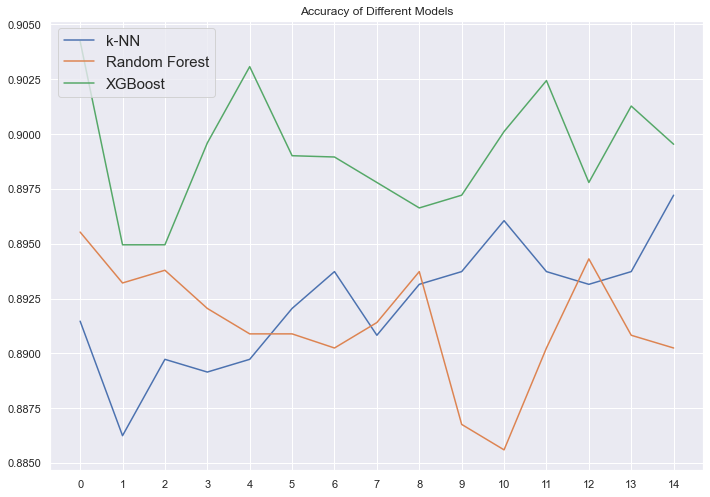

In [12]:
%%time

#Separating X values
x = OneHotDF
xVal = x.values

#Setting Parameters
randomState = 777
splits = 15
neighbors = 5

#Declaring CV object
cvStrat = StratifiedKFold(n_splits= splits, shuffle = True, random_state = randomState)

#Setting up basic models
knn = KNeighborsClassifier(n_neighbors = neighbors)
rf = RandomForestClassifier(random_state=randomState)
xgb = XGBClassifier(random_state=randomState, eval_metric='logloss')

#Separating target variable
y = bankData2['y']
y = y.ravel()

#Creating lists to store accuracy scores
knnAccs = []
rfAccs = []
xgbAccs = []

#Designating labels
labels = ['no', 'yes']

for trainIndices, testIndices in cvStrat.split(xVal,y): 
    
    #Term Subscription Prediction Testing/Training Splits
    xTrain = xVal[trainIndices]
    yTrain = y[trainIndices]
    yTrainBin = yTrain
    yTrainBin = (yTrainBin=='yes').astype(int)
    
    xTest = xVal[testIndices]
    yTest = y[testIndices]
    yTestBin = yTest
    yTestBin = (yTestBin=='yes').astype(int)
    
    #Scaled KNN training
    knn.fit(xTrain, yTrain) 
    yHatKnn = knn.predict(xTest)
    knnAccs.append(mt.accuracy_score(yTest,yHatKnn))
    
    #Scaled XGBoost training
    xgb.fit(xTrain, yTrainBin)
    yHatXgb = xgb.predict(xTest)
    xgbAccs.append(mt.accuracy_score(yTestBin, yHatXgb))
    
    #Scaled Random Forrest Training
    rf.fit(xTrain, yTrainBin)
    rfAccs.append(rf.score(xTest, yTestBin))

    
with warnings.catch_warnings(record=True):
    normalPlot = plt.figure(1)
    
    knnAccs = pd.Series(data = knnAccs)
    knnAccs.plot()
    
    rfAccs = pd.Series(data = rfAccs)
    rfAccs.plot()
    
    xgbAccs = pd.Series(data = xgbAccs)
    xgbAccs.plot()
    
    plt.xticks(np.arange(0, splits, 1))
    plt.title("Accuracy of Different Models")
    plt.legend(loc="upper left", labels = ['k-NN', 'Random Forest','XGBoost'], prop={'size': 15})
    
    normalPlot.show()

The figure above indicated that accuracy for the XGBoost model was consistently higher than random forest and k-NN. 

Given the performance shown in the figure above, it was clear that the scaled data

In [13]:
get_metrics_score(lrClf, flag=True)

NameError: name 'lrClf' is not defined

In [ ]:
make_confusion_matrix(lrClf, yTest, xTest, labels = ['no', 'yes'])

In [ ]:
make_confusion_matrix(knn, yTest, xTest, labels = ['no','yes'])

k-NN Mean Accuracy:  0.2993491530968705 
Random Forest Mean Accuracy:  0.4245041185176797 
XGBoost Mean Accuracy:  0.425275603307397
CPU times: total: 13min 17s
Wall time: 2min 33s


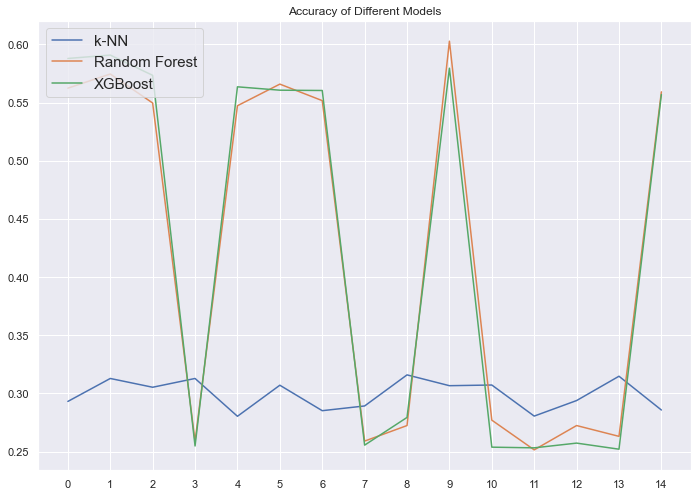

In [14]:
%%time
educVal = oneHotEduc.values
educY = educTarget.ravel()

#Creating lists to store accuracy scores
knnAccs = []
rfAccs = []
xgbAccs = []

#Creating Models for Multiclass
knn = KNeighborsClassifier(n_neighbors = neighbors)
rf = RandomForestClassifier(random_state=randomState)
xgb = XGBClassifier(random_state=randomState, eval_metric='logloss')

for trainIndices, testIndices in cvStrat.split(educVal,y):     
    #Education Prediction Testing/Training Splits
    educXTrain = educVal[trainIndices]
    educXTest = educVal[testIndices]

    educYTrain = educY[trainIndices]
    educYTest = educY[testIndices]
    educYTrainBin = pd.get_dummies(educYTrain).values.argmax(1)
    educYTestBin = pd.get_dummies(educYTest).values.argmax(1)
    #k-NN training
    knn.fit(educXTrain, educYTrain) 
    yHatKnn = knn.predict(educXTest)
    knnAccs.append(mt.accuracy_score(educYTest,yHatKnn))
    
    #XGBoost training
    xgb.fit(educXTrain, educYTrainBin)
    yHatXgb = xgb.predict(educXTest)
    xgbAccs.append(mt.accuracy_score(educYTestBin, yHatXgb))
    
    #Random Forrest Training
    rf.fit(educXTrain, educYTrainBin)
    rfAccs.append(rf.score(educXTest, educYTestBin))
    
with warnings.catch_warnings(record=True):
    print("k-NN Mean Accuracy: ", pd.Series(knnAccs).mean(),
          "\nRandom Forest Mean Accuracy: ", pd.Series(rfAccs).mean(),
          "\nXGBoost Mean Accuracy: ", pd.Series(xgbAccs).mean()
         )
    
    normalPlot = plt.figure(1)
    
    knnAccs = pd.Series(data = knnAccs)
    knnAccs.plot()
    
    rfAccs = pd.Series(data = rfAccs)
    rfAccs.plot()
    
    xgbAccs = pd.Series(data = xgbAccs)
    xgbAccs.plot()
    
    plt.xticks(np.arange(0, splits, 1))
    plt.title("Accuracy of Different Models")
    plt.legend(loc="upper left", labels = ['k-NN', 'Random Forest','XGBoost'], prop={'size': 15})
    
    normalPlot.show()

### Part 3

***Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!***

In [29]:
Y = np.where(y == 'yes', 1, 0)


In [33]:
xVal.shape

(25836, 50)

#### Random Forest

Accuracy 0.8968493574856788


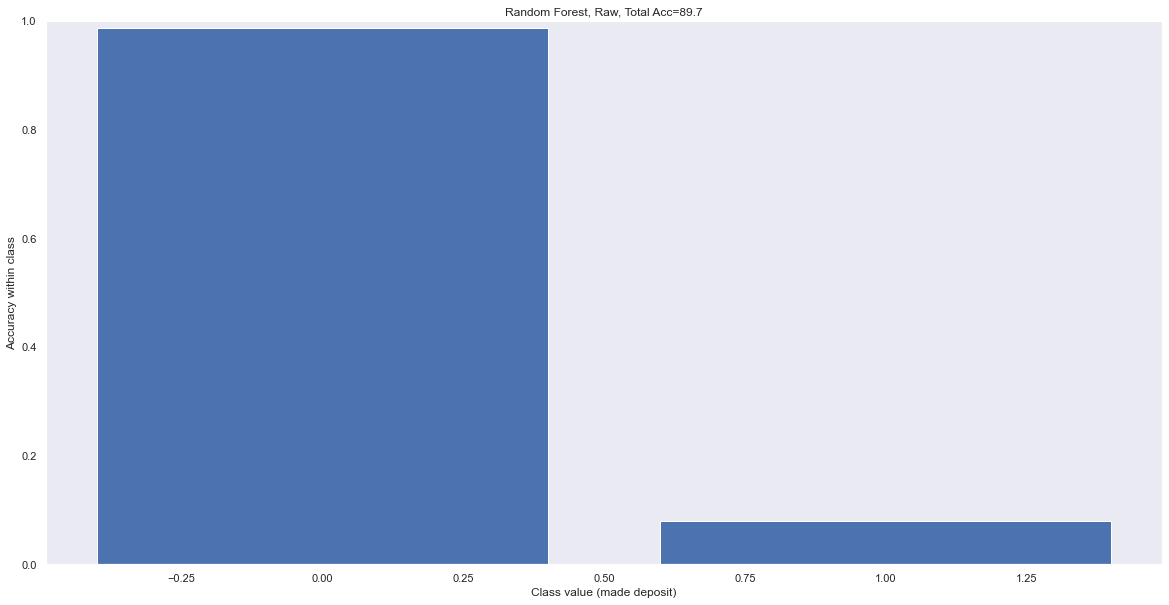

Pipeline accuracy 0.89789441089952


In [31]:
#Cross validation, using 80/20 train/test splitting
splits = 3
randomState=1
cv = ShuffleSplit(n_splits=splits, test_size=0.20, random_state=randomState)

# create variables we are more familiar with
yhat = np.zeros(educY.shape) # we will fill this with predictions

# %%time
from sklearn.ensemble import RandomForestClassifier
 
clf_pipe = Pipeline(
    [('PCA',PCA(n_components=43, svd_solver='randomized')),
     ('CLF',RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1))]
)

X = xVal

## model and score them 
clf = RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1, oob_score=True)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,Y):
    clf.fit(X[train],Y[train])
    yhat[test] = clf.predict(X[test])
    
def per_class_accuracy(ytrue,yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,yhat, title=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('Class value (made deposit)')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.ylim([0,1])
    plt.show()
    
total_accuracy = mt.accuracy_score(Y, yhat)
print ('Accuracy', total_accuracy)
plot_class_acc(Y,yhat,title="Random Forest, Raw")


# added yhat_score for ROC curve
yhat_score = np.zeros((y.shape[0],2))

# now iterate through and get predictions, saved to the correct row in yhat
## predict_proba  returns a vector 
for train, test in cv.split(X,Y):
    clf_pipe.fit(X[train],Y[train])
    yhat[test] = clf_pipe.predict(X[test])
    yhat_score[test] = clf_pipe.predict_proba(X[test])

total_accuracy = mt.accuracy_score(Y, yhat)
print ('Pipeline accuracy', total_accuracy)



#### XGBoost

In [ ]:
xgb = XGBClassifier(random_state=10, eval_metric='logloss')
xgb.fit(xTrain,yTrainBin)

#### KNN

### Part 4

***Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.***

### Part 5

***Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.***


because the data set is so skewed, a lot of people are not accepting short term deposit, we don't want all of the variables to be "no" answers because we only have a 10% "yes" rate.

## Part 6

***Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.***

## Deployment

***How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?***

## Exceptional Work

You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?